In [2]:
from lib.opt_types import *
from lib.utils import *
from lib.part_one import f, f_full_data, x_zero

# Stochastic gradient methods - 30 Points


In this problem, you will implement three different versions of stochastic gradient descent to solve the logistic regression problem on the entire NBA dataset.

In order to use the stochastic gradient descent methods, we recast our estimation problem [3](#mjx-eqn-eq3) as follows,

\begin{equation}
\tag{6}
f(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n\bigg\{\underbrace{\log(1 + \exp(- b_i \mathbf{a}_i^T\mathbf{x})) + \frac{\mu}{2}\|\mathbf{x}\|^2}_{f_i(\mathbf{x})}\bigg\},
\end{equation}

where we for notational convenience suppress the dependency on $\mu$.
As we saw in Problem 1, we have that

\begin{equation}
\nabla f_i(\mathbf{x}) = -b_i \sigma(-b_i \cdot \mathbf{a}_i^T\mathbf{x})\mathbf{a}_i + \mu \mathbf{x}.
\end{equation}

The objective function can be written as a sum of $n$ terms. We augment the `Function` type introduced in previous notebooks to include the following attributes:

- To access the gradient of the `j`-th term at a point `x` you can write `f.i_grad(j, x)`.
- The number of terms $n$ is stored in the attribute `f.n`. 

Consider the following stochastic gradient update: At the iteration $k$, pick $i_k\in\{1, \ldots, n\}$ uniformly at random and define

\begin{equation}
\mathbf{x}^{k+1} :=  \mathbf{x}^k - \alpha_k\nabla{f}_{i_k}(\mathbf{x}^k).\tag{SGD}
\end{equation}

----------------

__(a)__ (2 points) Show that $\nabla f_{i_k}(\mathbf{x})$ is an unbiased estimation of $\nabla f(\mathbf{x})$. Explain why $\nabla f_{i_k}$ is Lipschitz continuous with $L(f_{i_k}) = \|\mathbf{a}_{i_k}\|^2+ \mu $. 

__Hint__: Recall how we computed $L$ in Problem 1. In the following, we will set $L_{\max} = \max_{i\in\{1, \ldots, n\}}L(f_i)$.

ANSWER:

Since $i_k$ is chosen uniformly at random from ${1,...,n}$ a set of $n$ elements, then the probability of selecting any $i_k$ is $\frac{1}{n}$. Hence
$$E[\nabla f_{i_k}(x)] = \frac{1}{n} \sum_{i=1}^{n} \nabla f_i(x) = \nabla \frac{1}{n} \sum_{i=1}^{n} f_i(x)$$
Thus
$$\boxed{E[\nabla f_{i_k}(x)] = \nabla f(x)}$$

Let $x_1 < x_2$ in $\mathbb{R}$. We will prove that $\sigma$ is Lipschitz continuous. 

$\sigma$ is continuous due to composition of continuous functions.
Using the mean value theorem, there exist $c \in )x_1, x_2($ such that $$|| \sigma(x_1)-\sigma(x_2) || \leq \sigma'(c) ||x_1 - x_2 ||$$
We note that $\sigma'(x) = \frac{exp(-x)}{(1+exp(-x))^2}$ and this function is bounded by $\frac{1}{4}$.
Thus $\sigma$ is Lipschitz continuous and we have

$$|| \sigma(x_1)-\sigma(x_2) || \leq \frac{1}{4}  ||x_1 - x_2 || \leq ||x_1 - x_2 ||$$

Thus applied to $b_i \mathbf{a}_i^T\mathbf{x}$ we have

\begin{align}
|| \nabla f_{i_k}(x_1) - \nabla f_{i_k}(x_2) || &\leq || \sigma(b_i \mathbf{a}_i^T\mathbf{x_1})-\sigma(b_i \mathbf{a}_i^T\mathbf{x_2}) || ||a_{i_k}|| + \mu ||x_1 - x_2 ||  \\
&\leq || b_i \mathbf{a}_i^T\mathbf{x_1}-b_i \mathbf{a}_i^T\mathbf{x_2} || ||a_{i_k}|| + \mu ||x_1 - x_2 ||  \\
&\leq || x_1 - x_2 || ||a_{i_k}^T a_{i_k}|| + \mu ||x_1 - x_2 ||  \\
&\leq (||a_{i_k}||^2 + \mu )||x_1 - x_2 ||  \\
&\leq L(f_{i_k})||x_1 - x_2 ||  \\
\end{align}

Hence $\nabla f_{i_k}$ is Lipschitz continuous with $L(f_{i_k}) = \|\mathbf{a}_{i_k}\|^2+ \mu $. 


__(b)__ (2 points) 
We can use the standard stochastic gradient descent method [SGD](#mjx-eqn-eqSGD) to solve [6](#mjx-eqn-eq6). 
Implement `SGD` by completing the following cells with $\alpha_k =\frac{0.01}{k}$.

**Hint**: For some `N`, the function `np.random.choice(N)` generates a random integer in $\{0, \dots, N-1 \}$.


In [3]:
@dataclass
class SGD_state(OptState):
    x_k: Vector
    k: int

In [4]:
def SGD_update(f, state):
    x_k, k = state
    
    i_k = np.random.randint(1, f.n)

    grad_i_k = f.i_grad(i_k, x_k)

    alpha_k = 0.01 / k
    
    next_x_k = x_k - alpha_k * grad_i_k
    
    return SGD_state(next_x_k, k+1)

def SGD_initialize(f, x_zero):
    return SGD_state(x_zero, 1.0)

In [5]:
SGD = OptAlgorithm(name="SGD", init_state=SGD_initialize, state_update=SGD_update)

__(c)__ (6 points) 
Consider the following stochastic averaging gradient method [SAG](#mjx-eqn-eqSAG) to solve [6](#mjx-eqn-eq6):
\begin{equation}
\begin{cases}
\text{pick } i_k\in\{1, \ldots, n\} \text{ uniformly at random}\\
\mathbf{x}^{k+1} := \mathbf{x}^k - \frac{\alpha_k}{n}\sum_{i=1}^n\mathbf{v}_i^k,
\end{cases}
\end{equation}
where 
\begin{equation}
\mathbf{v}_i^k =
\begin{cases}
\nabla f_i(\mathbf{x}^k) &\text{if}\, i = i_k,\\
\mathbf{v}_i^{k-1} &\text{otherwise}.
\end{cases}
\end{equation}

Implement `SAG` by completing the following cells using the step-size 
$\alpha_k=\frac{0.01}{L_{\max}}$ and $\mathbf{v}^0=\mathbf{0}$. (Note that you can access $L_{\max}$ by writing `f.L_max`.

In [6]:
@dataclass
class SAG_state(OptState):
    x_k: Vector
    v_k: List[Vector]
    alpha_k: float

In [7]:
def SAG_update(f, state):
    x_k, v_k, alpha_k = state
    
    i_k = np.random.randint(1, f.n)
    
    for i in range(f.n):
        if (i == i_k):
            v_k[i] = f.i_grad(i, x_k)

    sum_v = np.zeros_like(x_zero)
    
    for j in range(f.n):
        sum_v += v_k[j]
        
    next_x_k = x_k - alpha_k / f.n * sum_v

    return SAG_state(next_x_k, v_k, alpha_k)

def SAG_initialize(f, x_zero):
    v_zero = np.tile(x_zero, (f.n, 1))
    alpha_k = 0.01 / f.L_max 
    return SAG_state(x_zero, v_zero, alpha_k)  

In [8]:
SAG = OptAlgorithm(name="SAG", init_state=SAG_initialize, state_update=SAG_update)

SAG    : 100%|██████████| 50000/50000 [01:32<00:00, 543.43it/s]


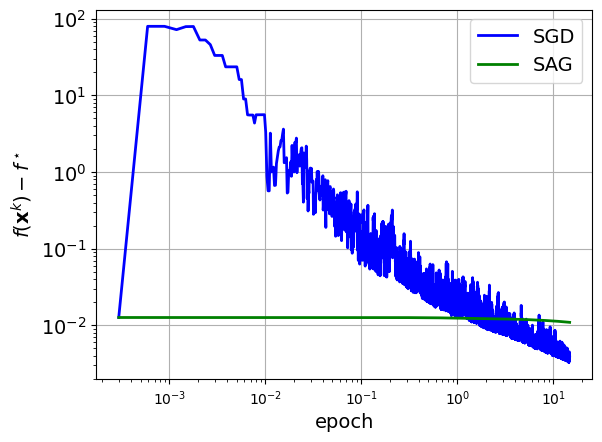

In [9]:
plot_epochs([SGD, SAG], f, x_zero, 50000)

__(d)__ (6 points) 
We can improve the convergence rate of SGD by periodically computing the full gradient. `SVRG` uses the following variance reduction scheme:
\begin{equation}
\begin{cases}
\text{if } k = 0 \text{ mod } q:\\
\quad \mathbf{z} = \mathbf{x}^k\\
\quad \tilde{\mathbf{v}} = \nabla f(\mathbf{x}^k)\\
\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
\mathbf{d}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}(\mathbf{z}) + \tilde{\mathbf{v}}\\
{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma\mathbf{d}^k\\
\end{cases}
\end{equation}

Implement `SVRG` by completing the following cells and fixing the following constant:
$\gamma = 1/L_{\max}$ and $q = 100$.

In [10]:
@dataclass
class SVRG_state(OptState):
    x_k: Vector 
    z: Vector
    tilde_v: Vector
    q: int
    gamma: float
    k: int

In [11]:
def SVRG_update(f, state):
    x_k, z, v_tilde, q, gamma, k = state
    
    if (k % q == 0):
        z = x_k
        v_tilde = f.grad(x_k)

    i_k = np.random.randint(1, f.n)

    d_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, z) + v_tilde

    next_x_k = x_k - gamma * d_k

    return SVRG_state(next_x_k, z, v_tilde, q, gamma, k+1)

def SVRG_initialize(f, x_zero):
    z_zero = x_zero
    tilde_v_zero = f.grad(x_zero)
    q = 100
    gamma = 1 / f.L_max
    
    return SVRG_state(x_zero, z_zero, tilde_v_zero, q, gamma, 1.0) 

In [12]:
SVRG = OptAlgorithm(name="SVRG", init_state=SVRG_initialize, state_update=SVRG_update)

__(e)__ (8 points) Another variance reduction method is `SARAH`. The scheme can be described as follows:

\begin{equation}
\begin{cases}
\text{if } k = 0 \text{ mod } q:\\
\quad {\mathbf{x}}^k = {\mathbf{z}}\\
\quad {\mathbf{v}}^k = \nabla f({\mathbf{z}})\\
\quad t \in \{0, \ldots, q-1\} \text{ uniformly at random}\\
\text{if } k = t \text{ mod } q:\\
\quad {\mathbf{z}} = {\mathbf{x}}^{k}\\
\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
{\mathbf{v}}^{k+1} = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}^{k-1}}) + {\mathbf{v}}^{k}\\
{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma {\mathbf{v}}^{k+1}\\
\end{cases}
\end{equation}


Implement `SARAH` by completing the following cells. Pick `q=100` and $\gamma = \frac{1}{L_\max}$.

In [13]:
@dataclass
class SARAH_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    v_k: Vector
    z: Vector
    q: int
    t: int
    gamma: float
    k: int

In [14]:
def SARAH_update(f, state):
    x_k, prev_x_k, v_k, z, q, t, gamma, k = state

    if (k % q == 0):
        x_k = z
        v_k = f.grad(z)
        t = np.random.choice(q)
    if (k % q == t):
        z = x_k

    i_k = np.random.randint(1, f.n)

    next_v_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, prev_x_k) + v_k

    next_x_k = x_k - gamma * next_v_k

    return SARAH_state(next_x_k, x_k, next_v_k, z, q, t, gamma, k+1)

def SARAH_initialize(f, x_zero):
    q = 100
    gamma = 1 / f.L_max
    return SARAH_state(x_zero, x_zero, x_zero, x_zero, q, 0, gamma, 1.0)

In [15]:
SARAH = OptAlgorithm(name="SARAH", init_state=SARAH_initialize, state_update=SARAH_update)

__(f)__ (6 points) Another variance reduction method is `Spider`. The scheme can be described as follows:

\begin{equation}
\begin{cases}
\text{if } k = 0 \text{ mod } q:\\
\quad {\mathbf{v}}^k = \nabla f({\mathbf{x}}^k)\\
\text{if } k \neq 0 \text{ mod } q:\\
\quad \text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
\quad {\mathbf{v}}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}}^{k-1}) + {\mathbf{v}}^{k-1}\\
\eta := \min \big(\frac{1}{\left \| {\mathbf{v}}^{k} \right \|_2}, \frac{1}{\epsilon}\big)\\
{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma \eta {\mathbf{v}}^{k}\\
\end{cases}
\end{equation}


Implement `Spider` by completing the following cells. Pick `q=100`, $\epsilon = 0.05$ and $\gamma = \frac{1}{L_{max}}$.

In [16]:
@dataclass
class Spider_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    prev_v_k: Vector
    q: int
    gamma: float
    k: int
    epsilon: float

In [17]:
import numpy
from numpy.linalg import norm

def Spider_update(f, state):
    x_k, prev_x_k, prev_v_k, q, gamma, k, epsilon = state

    if (k % q == 0):
        v_k = f.grad(x_k)
    else:
        i_k = np.random.randint(1, f.n)
        v_k = f.i_grad(i_k,x_k) - f.i_grad(i_k,prev_x_k) + prev_v_k
    
    eta = min( 1 / norm(v_k, 2) , 1 / epsilon )
    
    next_x_k = x_k - gamma * eta * v_k

    return Spider_state(next_x_k, x_k, v_k, q, gamma, k+1, epsilon)

def Spider_initialize(f, x_zero):
    q = 100
    gamma = 1 / f.L_max
    epsilon = 0.05
    return Spider_state(x_zero, x_zero, x_zero, q, gamma, 1.0, epsilon)

In [18]:
Spider = OptAlgorithm(name="Spider", init_state=Spider_initialize, state_update=Spider_update)

Spider :   0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_5558/841462317.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  eta = min( 1 / norm(v_k, 2) , 1 / epsilon )
Spider : 100%|██████████| 50000/50000 [01:20<00:00, 619.36it/s]


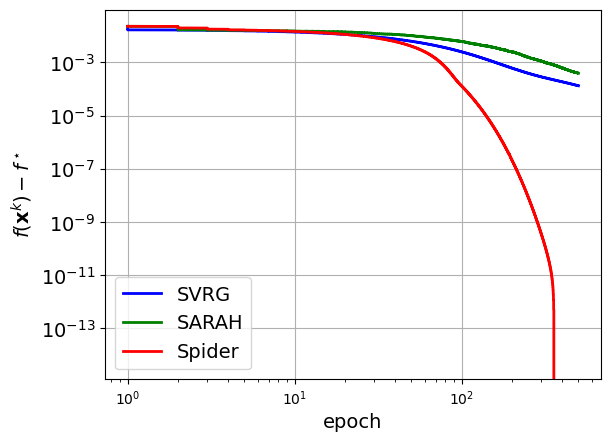

In [19]:
plot_epochs([SVRG, SARAH, Spider], f_full_data, x_zero, 50000)